<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# ComEd #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

### imports and graphics configurations ###

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
from matplotlib.backends.backend_agg import FigureCanvasAgg
import graphviz


import datetime
import urllib.request
import json

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['ElmanObserver.gv.png', 'ElmanPlant.gv.png', 'Jordan.gv.png', 'Jordanloop.gv.png', 'Jordantraining.gv.png', 'LSTM.gv.png', 'LSTMtrainingobserver.gv.png', 'LSTMtrainingplant.gv.png', 'PlantObserver.gv.png', 'tanh.png', 'timehorizon.png']
[None, None, None, None, None, None, None, None, None, None, None]


### configuration variables###

In [ ]:
N_samples=20
plot_color="blue"
ref_color="red"
SEED=0

In [ ]:
tz="America/Chicago"

### code starts here###

In [ ]:
def spot_prices(startDate,endDate):
    URL="https://hourlypricing.comed.com/api?type=5minutefeed&datestart={0:s}&dateend={1:s}"
    format="%Y%m%d%H%M"

    temp=URL.format(startDate.strftime(format),endDate.strftime(format))
    print(temp)
    with urllib.request.urlopen(temp) as response:
        data = response.read().decode('utf-8')
    print(data)

    return json.loads(data)

out=spot_prices(datetime.date(2021,5,1),datetime.date(2021,5,5))

https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202105010000&dateend=202105050000
[{"millisUTC":"1620190800000","price":"2.3"},{"millisUTC":"1620190500000","price":"2.2"},{"millisUTC":"1620190200000","price":"2.5"},{"millisUTC":"1620189900000","price":"2.6"},{"millisUTC":"1620189600000","price":"2.6"},{"millisUTC":"1620189300000","price":"2.7"},{"millisUTC":"1620189000000","price":"2.8"},{"millisUTC":"1620188700000","price":"2.7"},{"millisUTC":"1620188400000","price":"3.1"},{"millisUTC":"1620188100000","price":"3.1"},{"millisUTC":"1620187800000","price":"3.1"},{"millisUTC":"1620187500000","price":"2.3"},{"millisUTC":"1620187200000","price":"2.1"},{"millisUTC":"1620186900000","price":"2.4"},{"millisUTC":"1620186600000","price":"2.4"},{"millisUTC":"1620186300000","price":"2.3"},{"millisUTC":"1620186000000","price":"2.1"},{"millisUTC":"1620185700000","price":"2.1"},{"millisUTC":"1620185400000","price":"2.5"},{"millisUTC":"1620185100000","price":"2.7"},{"millisUTC":"16201848

In [ ]:
data_raw=pandas.DataFrame(out)
data=data_raw.copy()

In [ ]:
data["price"]=data["price"].astype("float")
data["millisUTC"]=data["millisUTC"].astype("int")
data["hour"]=data["millisUTC"].apply(lambda x: numpy.ceil(x/3.6E6)*3.6E6)
data["hour"]=pandas.DatetimeIndex(pandas.to_datetime(data["hour"],unit="ms")).tz_localize("UTC").tz_convert("America/Chicago")
data["time"]=pandas.DatetimeIndex(pandas.to_datetime(data["millisUTC"],unit="ms")).tz_localize("UTC").tz_convert("America/Chicago")

In [ ]:
spot=data["price"].squeeze()
spot.index=data["time"]
spot.index.name="time"
spot.name="spot price"
spot.sort_index(axis="index",inplace=True)
spot.head()

time
2021-05-01 00:00:00-05:00    1.7
2021-05-01 00:05:00-05:00    0.2
2021-05-01 00:10:00-05:00    1.8
2021-05-01 00:15:00-05:00    1.8
2021-05-01 00:20:00-05:00    0.2
Name: spot price, dtype: float64

In [ ]:
hourly=data.groupby("hour")["price"].mean().squeeze()
hourly.index.name="hourly price"
hourly.name="hourly price"
hourly.sort_index(axis="index",inplace=True)
hourly.head()

hourly price
2021-05-01 00:00:00-05:00    2.300000
2021-05-01 01:00:00-05:00    2.650000
2021-05-01 02:00:00-05:00    2.500000
2021-05-01 03:00:00-05:00    2.625000
2021-05-01 04:00:00-05:00    3.566667
Name: hourly price, dtype: float64

In [ ]:
(begin,end)=(datetime.datetime(2021,5,1,7,0,0),datetime.datetime(2021,5,2,0,0,0))

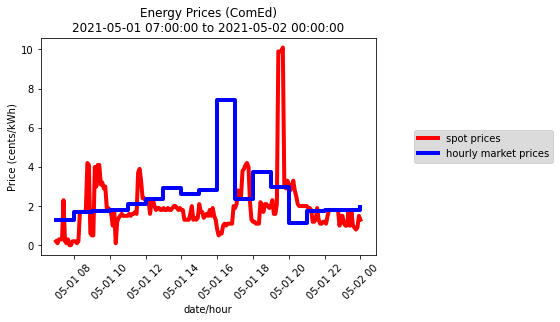

In [ ]:
temp_spot=spot[begin:end]
temp_hourly=hourly[begin:end]
plt.figure()
plt.plot(temp_spot.index,temp_spot,color="red",linewidth=4,label="spot prices")
plt.step(temp_hourly.index,temp_hourly,where="post",color="blue",linewidth=4,label="hourly market prices")
plt.ylabel("Price (cents/kWh)")
plt.xlabel("date/hour")
plt.xticks(rotation=45)
legend("side")
title=[]
title.append("Energy Prices (ComEd)")
title.append("{0:} to {1:}".format(begin,end))
plt.title("\n".join(title))
plt.show()
plt.close()